<a href="https://colab.research.google.com/github/sungjindo/python_study/blob/main/Timeseries_xgboost_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# install MlFlow
!pip install mlflow --quiet
!pip install pyngrok --quiet

     |████████████████████████████████| 745 kB 4.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [40]:
#Check whether MLFlow is installed or not
!mlflow

Usage: mlflow [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  artifacts    Upload, list, and download...
  azureml      Serve models on Azure ML.
  db           Commands for managing an...
  deployments  Deploy MLflow models to custom...
  experiments  Manage experiments.
  gc           Permanently delete runs in the
               `deleted` lifecycle stage.
  models       Deploy MLflow models locally.
  run          Run an MLflow project from the...
  runs         Manage runs.
  sagemaker    Serve models on SageMaker.
  server       Run the MLflow tracking server.
  ui           Launch the MLflow tracking UI...


In [41]:
#Let's do it
import mlflow
import mlflow.sklearn

mlflow.set_experiment('LearnML-Demo')

2022/07/10 06:07:30 INFO mlflow.tracking.fluent: Experiment with name 'LearnML-Demo' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/1', experiment_id='1', lifecycle_stage='active', name='LearnML-Demo', tags={}>

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
import mlflow
import mlflow.sklearn
import sys
import os

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [63]:
def eval_metrics(actual, pred):
  rmse = np.sqrt(mean_squared_error(actual,pred))
  mae = mean_absolute_error(actual, pred)
  mape = mean_absolute_percentage_error(actual, pred)
  r2 = r2_score(actual, pred)

  return rmse, mae, mape, r2
                                                         

In [49]:
path = '/content/gdrive/MyDrive/hourly energy consumption'
data = pd.read_csv(path+ '/PJME_hourly.csv') 
data = data.set_index('Datetime')
data

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [54]:
# # mlflow_tracking.py
# import os
# from random import random, randint

# from mlflow import log_metric, log_param, log_artifacts

# if __name__ == "__main__":
#     print("Running mlflow_tracking.py")

#     log_param("param1", randint(0, 100))

#     log_metric("foo", random())
#     log_metric("foo", random() + 1)
#     log_metric("foo", random() + 2)

#     if not os.path.exists("outputs"):
#         os.makedirs("outputs")
#     with open("outputs/test.txt", "w") as f:
#         f.write("hello world!")

#     log_artifacts("outputs")

# MLflow

- MLflow는 End to End로 머신러닝 라이프 사이클을 관리할 수 있는 오픈소스
- 데이터브릭스에서 만듬
- 데이터브릭스 hosted version
- 주요 기능 
- 1) MLflow Tracking
  - 파라미터와 결과를 비교하기 위해 실험 결과를 저장
- 2) MLflow Projects
  * 머신러닝 코드를 재사용 가능하고 재현 가능한 형태로 포장
  * 포장된 형태를 다른 데이터 사이언티스트가 사용하거나 프러덕션에 반영
- 3) MLflow Models
  - 다양한 ML 라이브러리에서 모델을 관리하고 배포, Serving, 추론
  - REST API, CLI를 통해 모든 기능에 액세스 할 수 있기 때문에 모든 라이브러리, 프로그래밍 언어에서 사용 가능
  - API는 Python, R, Java 존재

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [3]:
path = '/content/gdrive/MyDrive/hourly energy consumption'

In [4]:
df = pd.read_csv(path+ '/PJME_hourly.csv') 
df = df.set_index('Datetime')

In [5]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


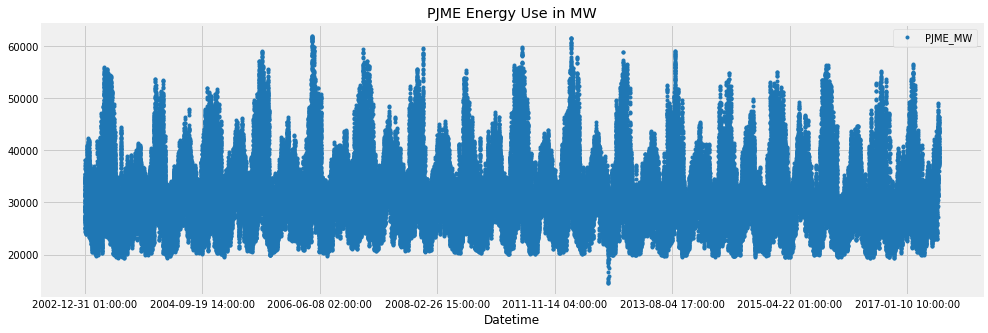

In [6]:
df.plot(style = '.', figsize=(15,5), color = color_pal[0], title='PJME Energy Use in MW')

In [7]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [8]:
df.index = pd.to_datetime(df.index)

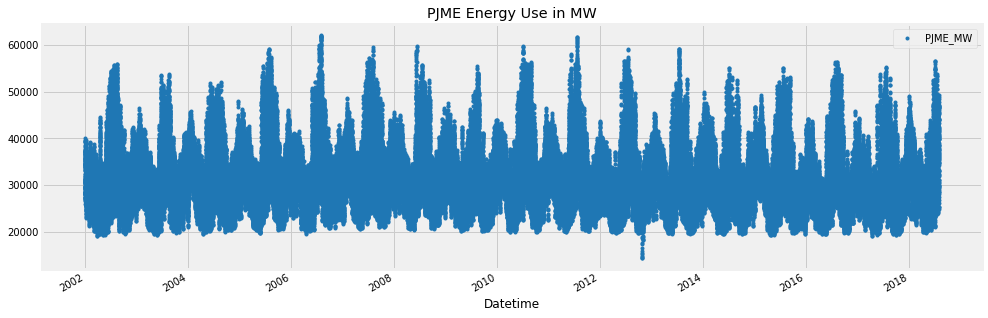

In [9]:
df.plot(style = '.', figsize=(15,5), color = color_pal[0], title='PJME Energy Use in MW')

# Train/Test split

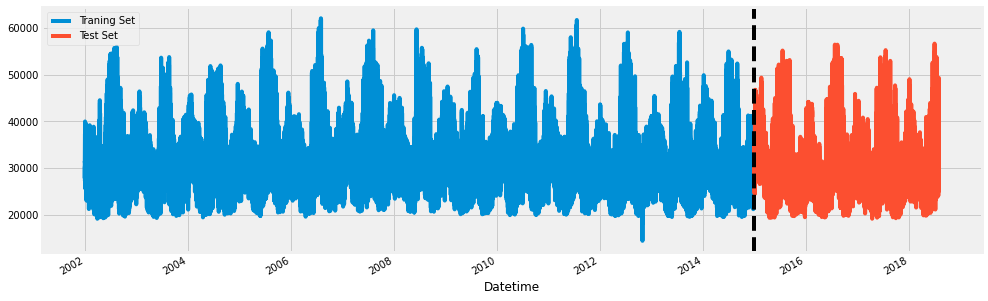

In [10]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index>= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Traning Set', 'Test Set'])  
plt.show()

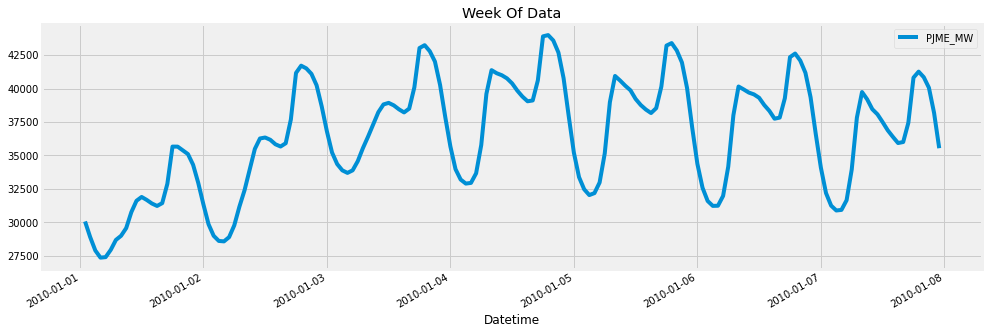

In [11]:
df.loc[(df.index > '01-01-2010')&(df.index<'01-08-2010')].plot(figsize=(15,5), title='Week Of Data')
plt.show()

# Feature Creation

In [57]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)


# Visualitze our Feeature / Target Relationship

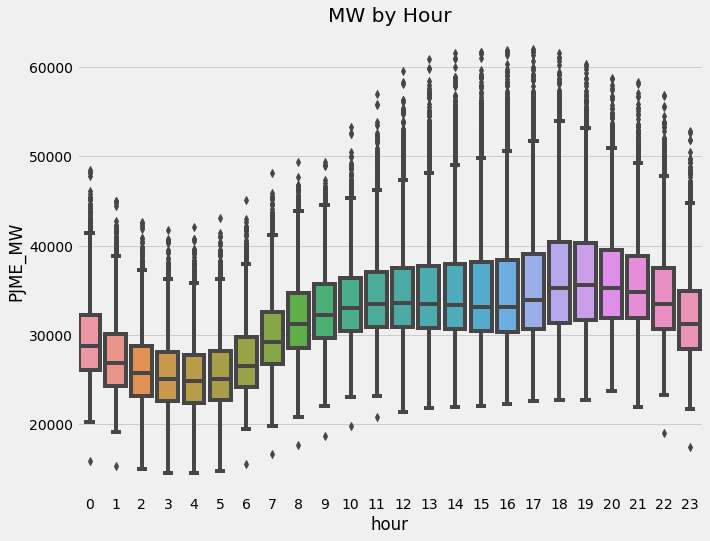

In [ ]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

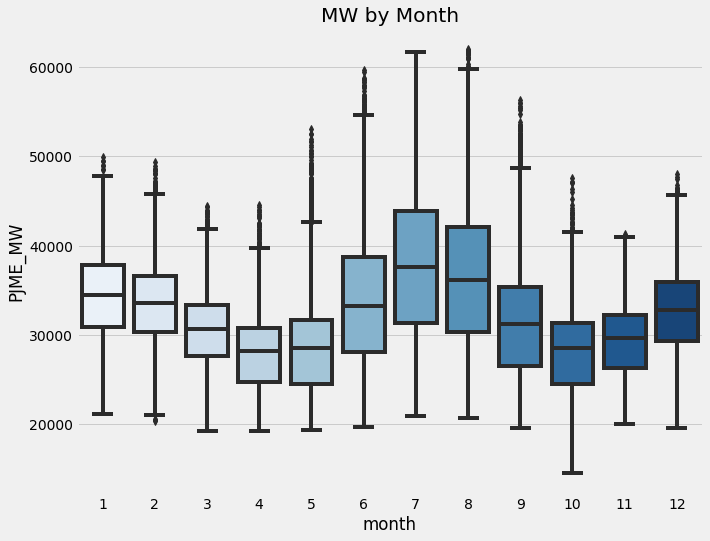

In [ ]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette= 'Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [64]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [65]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       ]
TARGET = 'PJME_MW'
def train_model(df,split_date):
  train = df.loc[df.index < split_date]
  test = df.loc[df.index >= split_date]
  train = create_features(train)
  test = create_features(test)
  X_train = train[FEATURES]
  y_train = train[TARGET]
  X_test = test[FEATURES]
  y_test = test[TARGET]
  
  with mlflow.start_run(nested=True):
    reg = xgb.XGBRegressor(n_estimators = 1000,early_stipping_rounds=50,
                      learning_rate = 0.01)
    reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=100)
    test['prediction'] = reg.predict(X_test)
    df = df.merge(test[['prediction']], how ='left', left_index=True, right_index=True)

    (rmse, mae, mape, r2) = eval_metrics(y_test, test['prediction'])

    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.log_metric('mae', mae)
    mlflow.log_metric('mape', mape)

    mlflow.sklearn.log_model(reg, 'model')

In [66]:
train_model(df, '01-01-2015')

[06:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.1	validation_1-rmse:31657.1
[100]	validation_0-rmse:12581.2	validation_1-rmse:11743.7
[200]	validation_0-rmse:5835.05	validation_1-rmse:5365.67
[300]	validation_0-rmse:3915.7	validation_1-rmse:4020.66
[400]	validation_0-rmse:3443.11	validation_1-rmse:3853.4
[500]	validation_0-rmse:3285.31	validation_1-rmse:3805.31
[600]	validation_0-rmse:3201.91	validation_1-rmse:3772.44
[700]	validation_0-rmse:3148.12	validation_1-rmse:3750.92
[800]	validation_0-rmse:3109.22	validation_1-rmse:3733.9
[900]	validation_0-rmse:3079.37	validation_1-rmse:3725.61
[999]	validation_0-rmse:3052.71	validation_1-rmse:3722.92


2022/07/10 06:50:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpqgzrnnli/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==1.3.0']. Set logging level to DEBUG to see the full traceback.


In [97]:
from pyngrok import ngrok

# Terminate open trummerls if exist
ngrok.kill()

# Setting the aythtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2Bk4NqxL9drDcqFSkUlIbSSG82R_29RZ2GtbLRN6phbj6rz99"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

#Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr='5000', proto='http', bind_tls=True)
print("MLflow Tracking UI", ngrok_tunnel.public_url)

MLflow Tracking UI https://8204-34-73-214-86.ngrok.io


In [98]:
!ngrok config add-authtoken 2Bk4NqxL9drDcqFSkUlIbSSG82R_29RZ2GtbLRN6phbj6rz99

NAME:
   ngrok - tunnel local ports to public URLs and inspect traffic

DESCRIPTION:
    ngrok exposes local networked services behinds NATs and firewalls to the
    public internet over a secure tunnel. Share local websites, build/test
    webhook consumers and self-host personal services.
    Detailed help for each command is available with 'ngrok help <command>'.
    Open http://localhost:4040 for ngrok's web interface to inspect traffic.

EXAMPLES:
    ngrok http 80                    # secure public URL for port 80 web server
    ngrok http -subdomain=baz 8080   # port 8080 available at baz.ngrok.io
    ngrok http foo.dev:80            # tunnel to host:port instead of localhost
    ngrok http https://localhost     # expose a local https server
    ngrok tcp 22                     # tunnel arbitrary TCP traffic to port 22
    ngrok tls -hostname=foo.com 443  # TLS traffic for foo.com to port 443
    ngrok start foo bar baz          # start tunnels from the configuration file

VERSI

In [ ]:
!mlflow ui

[2022-07-10 07:16:58 +0000] [2537] [INFO] Starting gunicorn 20.1.0
[2022-07-10 07:16:58 +0000] [2537] [INFO] Listening at: http://127.0.0.1:5000 (2537)
[2022-07-10 07:16:58 +0000] [2537] [INFO] Using worker: sync
[2022-07-10 07:16:58 +0000] [2540] [INFO] Booting worker with pid: 2540


In [79]:
!unzip /content/gdrive/MyDrive/ngrok-v3-stable-windows-amd64.zip

Archive:  /content/gdrive/MyDrive/ngrok-v3-stable-windows-amd64.zip
  inflating: ngrok.exe               


In [80]:
!ngrok config add-authtoken 2Bk4NqxL9drDcqFSkUlIbSSG82R_29RZ2GtbLRN6phbj6rz99

NAME:
   ngrok - tunnel local ports to public URLs and inspect traffic

DESCRIPTION:
    ngrok exposes local networked services behinds NATs and firewalls to the
    public internet over a secure tunnel. Share local websites, build/test
    webhook consumers and self-host personal services.
    Detailed help for each command is available with 'ngrok help <command>'.
    Open http://localhost:4040 for ngrok's web interface to inspect traffic.

EXAMPLES:
    ngrok http 80                    # secure public URL for port 80 web server
    ngrok http -subdomain=baz 8080   # port 8080 available at baz.ngrok.io
    ngrok http foo.dev:80            # tunnel to host:port instead of localhost
    ngrok http https://localhost     # expose a local https server
    ngrok tcp 22                     # tunnel arbitrary TCP traffic to port 22
    ngrok tls -hostname=foo.com 443  # TLS traffic for foo.com to port 443
    ngrok start foo bar baz          # start tunnels from the configuration file

VERSI

In [84]:
# in ngrok.yml
# authtoken: 2Bk4NqxL9drDcqFSkUlIbSSG82R_29RZ2GtbLRN6phbj6rz99

SyntaxError: ignored

In [ ]:
train = create_features(train)
test = create_features(test)


In [ ]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       ]
TARGET = 'PJME_MW'

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators = 1000,early_stipping_rounds=50,
                      learning_rate = 0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=100)
    

[04:51:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.1	validation_1-rmse:31657.1
[100]	validation_0-rmse:12581.2	validation_1-rmse:11743.7
[200]	validation_0-rmse:5835.05	validation_1-rmse:5365.67
[300]	validation_0-rmse:3915.7	validation_1-rmse:4020.66
[400]	validation_0-rmse:3443.11	validation_1-rmse:3853.4
[500]	validation_0-rmse:3285.31	validation_1-rmse:3805.31
[600]	validation_0-rmse:3201.91	validation_1-rmse:3772.44
[700]	validation_0-rmse:3148.12	validation_1-rmse:3750.92
[800]	validation_0-rmse:3109.22	validation_1-rmse:3733.9
[900]	validation_0-rmse:3079.37	validation_1-rmse:3725.61
[999]	validation_0-rmse:3052.71	validation_1-rmse:3722.92


XGBRegressor(early_stipping_rounds=50, learning_rate=0.01, n_estimators=1000)

# Feature Importance

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_, 
            index=reg.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh',title = 'Feature Importance')
plt.show()

AttributeError: ignored

# Forecast on Test

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how ='left', left_index=True, right_index=True)
df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
df.loc[(df.index > '04-01-2018')&(df.index<'04-08-2018')].plot(figsize=(15,5), title='Week Of Data')
plt.show()

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# error

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

# Calculate Error

In [ ]:
test['error'] = np.abs(test[TARGET]-test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

In [ ]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

# Next steps
- More robust cross validation|